Using the other object as test set 🤪

In [44]:
# Bonus cell for using the different test set

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2
import time
from joblib import dump, load
# Två delar:
# 1: fixa segmentstorleken
# 2: fixa masker för varje segment
# Eller egentligen, skit i det. Applicera masken i förväg?


def getTestObjects(oldLayers=np.array([[[[]]]]), nextLayer=0, porositythreshold=0.5):
    # _, layer, _, _ = np.shape(oldLayers)
    objectwidth = 100
    objectheight = 100
    xspacing = 116
    yspacing = 300
    xstart = 293
    ystart = 445
    xend = 1730
    yend = 1770
    powderthickness = 80
    endlayer = 225
    vsegments = [0, 150, 187, endlayer]

    ###### Could make this more effective
    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
    ######

    paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths][0:225]
    paths_sorted.sort()
    filename = f"models/B/mask.joblib"
    mask = load(filename)
    if nextLayer == 0:
        # Vi har objekt som vi lägger datan på... Börja med itereringen
        oldLayers = np.full((len(coorddf), endlayer, objectheight, objectwidth), np.nan)
        integrals = np.array([plt.imread(path) for path in paths_sorted[0:5]])
        for index, object in coorddf.iterrows():
            oldLayers[index, 0:5] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
            oldLayers[index, 0:5][~mask[0:5]] = np.nan
    else:
        nextLayerData = plt.imread(paths_sorted[nextLayer])
        for index, object in coorddf.iterrows():
            oldLayers[index, nextLayer] = nextLayerData[object.ystart:object.yend, object.xstart:object.xend]
            oldLayers[index, nextLayer][~mask[nextLayer]] = np.nan
    objects = oldLayers
        # for object in objects:
        #     object[~mask] = np.nan
        # nextLayerData[~mask[nextLayer]] = np.nan
        # Lägg nästa lager på nuvarande lager

    
    # integrals = np.load('integrals.npy')
    # t1 = time.time()

    # print("Reading time was: ", (t1 - start_time))
    # np.save('integrals.npy', integrals)
    # t11 = time.time()
    # print("Saving time was: ", (t11 - t1))
    # integrals = np.load('integrals.npy')
    # t12 = time.time()
    # print("Loading time was: ", (t12 - t11))

    # aggregate = np.sum(objects, axis=(0))

    # emptyRatio = 30
    # limit = np.percentile(aggregate, emptyRatio)
    # testmask = aggregate >= limit
    
    # t2 = time.time()
    # print("Mask time was: ", (t2 - t1))

    # Create the good frame
    segmentdf = pd.read_csv('Segments2.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity"])
    segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
    segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
    # segmentdf.drop(segmentdf[(segmentdf.VED > 50)].index, inplace=True)
    segmentdf.reset_index(drop=True, inplace=True)
    vs = [[vsegments[j], vsegments[j+1]] for i in range(0, len(objects)) for j in reversed(range(0, len(vsegments)-1))]
    coorddf = pd.DataFrame(vs, columns=['zstart', 'zend'])
    testobjectinfo = coorddf.join(segmentdf)
    testobjectinfo.drop(testobjectinfo[(testobjectinfo.Objectnumber == 28) | (testobjectinfo.Objectnumber == 21) ].index, inplace=True)
    testobjectinfo.drop(testobjectinfo[(testobjectinfo.zstart < nextLayer-4)].index, inplace=True)
    testobjectinfo.reset_index(drop=True, inplace=True)

    t3 = time.time()
    # print("Dftime was: ", (t3 - t2))

    testobjects = [objects[object.Objectnumber-1, object.zstart:object.zend] for index, object in testobjectinfo.iterrows()]

    t4 = time.time()
    # print("objectsplittime was: ", (t4 - t3))
    # print("Totaltime was: ", (t4 - start_time))
    return testobjects, testobjectinfo, objects


In [45]:
# Read train data
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

def getTrainObjects(oldLayers=np.array([[[[]]]]), nextLayer=0,objectsplit=1, upsamplingratio=1, positive_multiplier=1, porositythreshold=0.5, separate_test=True):
    emptyRatio = 47
    objectwidth = 83
    objectheight = 122
    xspacing = 133
    yspacing = 270
    xstart = 293
    ystart = 268
    xend = 1730
    yend = 1770
    hsegments = [0,26,50,74,98,122]
    powderthickness = 80
    endlayer = 187

    ###### Could make this more effective
    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
    ######

    paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths][0:225]
    paths_sorted.sort()
    filename = f"models/A/mask.joblib"
    mask = load(filename)
    if nextLayer == 0:
        # Vi har objekt som vi lägger datan på... Börja med itereringen
        oldLayers = np.full((len(coorddf), endlayer, objectheight, objectwidth), np.nan)
        integrals = np.array([plt.imread(path) for path in paths_sorted[0:5]])
        for index, object in coorddf.iterrows():
            oldLayers[index, 0:5] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
            oldLayers[index, 0:5][~mask[0:5]] = np.nan
    else:
        nextLayerData = plt.imread(paths_sorted[nextLayer])
        for index, object in coorddf.iterrows():
            nextLayerData[object.ystart:object.yend, object.xstart:object.xend][~mask[nextLayer]] = np.nan
            oldLayers[index, nextLayer] = nextLayerData[object.ystart:object.yend, object.xstart:object.xend]
            # oldLayers[index, nextLayer][~mask[nextLayer]] = np.nan
    objects = oldLayers

    segmentdf = pd.read_csv('Segments.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity", "Area"])
    segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
    segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
    hs = [[hsegments[j], hsegments[j+1]] for i in range(0, len(objects)) for j in range(0, len(hsegments)-1)]
    coorddf = pd.DataFrame(hs, columns=['hstart', 'hend'])
    segmentdf = coorddf.join(segmentdf)

    # Start of object multiplication 
    layersPerObject = endlayer // objectsplit
    testEnd = endlayer if separate_test else endlayer - layersPerObject * (objectsplit // 3)
    zs = [segmentdf.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject+1, layersPerObject//(upsamplingratio * positive_multiplier))]
    # testzs = [segmentdf.copy().assign(zstart=testEnd, zend=endlayer)]
    trainobjectinfo = pd.concat(zs, ignore_index=True)
    trainobjectinfo.drop(trainobjectinfo[(trainobjectinfo.Objectnumber == 28) | (trainobjectinfo.Objectnumber == 21) ].index, inplace=True)
    trainobjectinfo.reset_index(drop=True, inplace=True)
    # testobjectinfo = pd.concat(testzs, ignore_index=True)
    # testobjectinfo.drop(testobjectinfo[(testobjectinfo.Objectnumber == 28) | (testobjectinfo.Objectnumber == 21) ].index, inplace=True)
    # testobjectinfo.reset_index(drop=True, inplace=True)

    # Removes extra rows 
    trainobjectinfo = trainobjectinfo[(trainobjectinfo['Label'] == 1) | (trainobjectinfo['zstart'] % (positive_multiplier) == 0)]

    trainobjects = [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in trainobjectinfo.iterrows()]
    # testobjects = [objects[object.Objectnumber-1, object.zstart:object.zend, object.hstart:object.hend] for index, object in testobjectinfo.iterrows()]

    # print("fetching data with objectsplit: {}, upsamplingratio: {}, positive_multiplier: {}, porositythreshold: {}".format(objectsplit, upsamplingratio, positive_multiplier, porositythreshold))
    return trainobjects, trainobjectinfo, objects

# assert(np.average(np.isfinite(trainobjects)) == 1)
# assert(np.average(np.isfinite(testobjects)) == 1)
# xs = np.copy(aggregate)
# xs[~backgroundmask] = np.nan
# plt.imshow(xs)
# plt.figure()

In [46]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import tree
import warnings

def preprocess(objects, type, sharpening):
    rtn = []
    # print(rtn.shape)
    for index, object in enumerate(objects):
        object = np.copy(object)
        sharpened = object
        if(sharpening != 'none'):
            sharpeningKernel = np.array([   [-1, -1,  -1],
                                        [-1,  9,  -1],
                                        [ -1, -1,  -1]
        ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                        [-1, 5, -1],
                                                        [0, -1,  0]])
            sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
        # Sharpening is done
        if type == 'scatter' or type == 'spatstat':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            rtn.append(xs)
        elif type == 'moran':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            avg = np.nanmean(xs)
            stddev = np.nanstd(xs)
            xs = (xs - avg) / avg
            rtn.append(xs)
    return rtn


def calculateoutliers(objects, type, neighbourhoodSetting, windowSize):
    # c, z, y, x = objects.shape


    outlierValues = []
    index = 0
    # return objects
    for object in objects:
        object = np.copy(object)
        z, y, x = object.shape
        # Step 1: calculate neighbourhood
        neighbourkernel = np.ones((neighbourhoodSetting, neighbourhoodSetting)) / neighbourhoodSetting**2
        flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
        neighbourhoodValues = np.array([
            np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
            for layerIndex in range(windowSize, z+1)
        ])
        # Step 2: calculate outlier
        offset = windowSize // 2
        endoffset = windowSize - offset - 1

        ys = neighbourhoodValues[0:z-windowSize+1]
        xs = object[offset:z-endoffset]
        filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

        # plt.imshow(xs[0])
        # plt.figure()
        # plt.imshow(xs[0])
        # plt.figure()
        # if(index == 58):
        #     plt.imshow(xs[0])
        #     plt.figure()
        #     plt.imshow(ys[0])
        #     plt.figure()
        #     plt.imshow(filter[0])
        #     plt.figure()
        #     print(len(np.unique(filter)))
        numberOfFilterValues = len(np.unique(filter))
        # print("filterlength is: ", numberOfFilterValues)
        # print("index is:", index)
        assert numberOfFilterValues == 2, f"Expected filter to have two values, got: {numberOfFilterValues}"
        if type == 'spatstat':
            outliers = xs - ys
            avg = np.mean(outliers[filter])
            std = np.std(outliers[filter])
            outliers = (outliers - avg) / std
            outlierValues.append(outliers)
        else:
            with warnings.catch_warnings():
                line = np.polyfit(xs[filter].flatten(), ys[filter].flatten(), 1)
                p = np.poly1d(line)
                outlierValues.append(p(xs) - ys)
            assert(xs.shape == p(ys).shape)
        assert(len(np.unique(outlierValues[index])) > 1)
        assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
        index+=1
    return outlierValues

def encode(outlierobjects, buckets, minval=0, maxval=0):
    numberOfObjects = len(outlierobjects)
    X = np.full((numberOfObjects, buckets), np.nan)
    raw = np.concatenate([oo.flatten() for oo in outlierobjects])
    filter = np.isfinite(raw)
    minval = np.min(raw[filter]) if minval == 0 else minval
    maxval = np.max(raw[filter]) if maxval == 0 else maxval
    for index in range(0, numberOfObjects):
        xs = outlierobjects[index]
        filter = np.isfinite(xs)
        hist, edges = np.histogram(xs[filter], bins=buckets, range=(minval, maxval), density=True)
        X[index] = np.array(hist)
    
    return X, minval, maxval, edges

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, classifier):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1) if classifier == 'KNN' else tree.DecisionTreeClassifier(max_depth=n_neighbors*2, class_weight='balanced', random_state=42)
    clf2 = clf
    scaler = StandardScaler()
    clf = Pipeline([('scaler', scaler), ('classifier', clf)])
    # splits = [(np.arange(0,130,1), np.arange(130,260,1)), (np.arange(130,260,1), np.arange(0,130,1))]
    cvs = cross_val_score(clf, Xtrain, Ytrain, cv=10, scoring='roc_auc', n_jobs=-1)
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict_proba(Xtest)[:,1]

    return cvs.mean(), metrics.roc_auc_score(Ytest, yfit), clf

In [47]:
from sklearn import metrics
from joblib import dump, load
# Now to tie it all together...

def getPodAndRoc (folder, Xtrain, Ytrain, Xtest, Ytest, classifier, type, z, xy, bins, hyperparameter):
    sharpSetting = 'none'

    trainpreprocessed =preprocess(Xtrain, type, sharpSetting)
    testpreprocessed =preprocess(Xtest, type, sharpSetting)

    trainoutliers = calculateoutliers(trainpreprocessed, type, xy, z)
    testoutliers = calculateoutliers(testpreprocessed, type, xy, z)

    Xtrain, minval, maxval, edges = encode(trainoutliers, bins)
    Xtest, _, _, _ = encode(testoutliers, bins, minval=minval, maxval=maxval)

    # Print in the classify function, can't do it outside? 
    # Xtrain, Ytrain, Xtest, Ytest, n_neighbors, classifier
    Ypred, Yprobs, clf = classify(Xtrain, Ytrain, Xtest, Ytest, hyperparameter, classifier,)

    filename = f"models/{folder}/{classifier}_{type}_{z}_{xy}_{bins}_{hyperparameter}.joblib"
    dump(clf, filename) 
    
    # limits = np.logspace(-1, 1, num=20)
    # limits = np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2])

    # recall = [metrics.recall_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
    # precision = [metrics.precision_score(np.where(testobjectinfo.Porosity > limit, 1, 0), Ypred) for limit in limits ]
    
    return Ypred, Yprobs

In [48]:
def justPredict (folder, Xtest, classifier, type, z, xy, bins, hyperparameter):
    sharpSetting = 'none'
    testpreprocessed =preprocess(Xtest, type, sharpSetting)
    testoutliers = calculateoutliers(testpreprocessed, type, xy, z)
    Xtest, _, _, _ = encode(testoutliers, bins)
    # Print in the classify function, can't do it outside? 
    # Xtrain, Ytrain, Xtest, Ytest, n_neighbors, classifier
    # Ypred, Yprobs, clf = classify(Xtrain, Ytrain, Xtest, Ytest, hyperparameter, classifier,)
    clf = load(f"models/{folder}/{classifier}_{type}_{z}_{xy}_{bins}_{hyperparameter}.joblib")
    Ypred = clf.predict(Xtest)
    
    return Ypred

In [49]:
# # Now to tie it all together...
# def doStuff (outputfile, trainobjects, Ytrain, testobjects, Ytest, classifier):
#     columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'cv-auc', 'test-auc',]
#     results = pd.DataFrame(columns=columns)
#     for type in types:
#         for sharpSetting in sharpening:
#             trainpreprocessed =preprocess(trainobjects, type, sharpSetting)
#             testpreprocessed =preprocess(testobjects, type, sharpSetting)
#             for windowsize in windowsizes:
#                 for nSetting in neighbourhoodsize:
#                     trainoutliers = calculateoutliers(trainpreprocessed, type, nSetting, windowsize)
#                     testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
#                     for histnorm in histnormalise:
#                         for bincount in bins:
#                             Xtrain, minval, maxval, edges = encode(trainoutliers, bincount)
#                             Xtest, _, _, _ = encode(testoutliers, bincount, minval=minval, maxval=maxval)
#                             for n_neighbors in k:
#                                 cvscore, score = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, histnorm, classifier)
#                                 nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bincount, histnorm, n_neighbors, cvscore, score]], columns=columns)
#                                 results = pd.concat([results, nextRow])
#                             results.to_csv(outputfile, index=False, header=True)

In [51]:
# Training cell B

settingcolumns = ['threshold', 'classifier', 'type', 'z', 'xy', 'bins', 'hyperparameter']
bsettings =  pd.DataFrame([
    [0.1,'KNN','moran',1,7,20,5,],
    [0.1,'KNN','moran',1,5,20,11,],
    [0.1,'KNN','spatstat',1,5,5,5,],
    [0.25,'KNN','moran',1,7,40,7,],
    [0.25,'KNN','moran',1,5,40,11,],
    [0.25,'KNN','moran',1,3,10,7,],
    [0.5,'KNN','spatstat',1,7,40,11,],
    [0.5,'KNN','moran',1,7,40,7,],
    [0.5,'KNN','moran',1,5,40,11,],
], columns=settingcolumns)
asettings =  pd.DataFrame([
    [0.1,'KNN','moran',1,7,20,5,],
    [0.1,'KNN','moran',1,5,40,5,],
    [0.1,'KNN','scatter',1,5,40,5,],
    [0.25,'KNN','scatter',3,5,40,5,],
    [0.25,'KNN','scatter',1,7,10,7,],
    [0.25,'KNN','scatter',1,3,20,5,],
    [0.5,'KNN','scatter',1,3,20,5,],
    [0.5,'KNN','moran',1,7,40,11,],
    [0.5,'DT','scatter',1,7,40,11,],
], columns=settingcolumns)
# trainobjects, trainobjectinfo = getTrainObjects(porositythreshold=0.5, separate_test=True)
# testobjects, testobjectinfo = getTestObjects(porositythreshold=0.5)
# Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
# Ytest = np.array(testobjectinfo.loc[:,"Label"])
# scoresMap = {}
    
# for threshold in [0.1, 0.25, 0.5]:
#     Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
#     porosity = np.array(trainobjectinfo.loc[:,"Porosity"])
#     Xtrain, Xtest, Ytrain, Ytestporosity = train_test_split(trainobjects, porosity, test_size=0.33, random_state=42)
#     Ytest = np.where(Ytestporosity > threshold, 1, 0)
#     Ytrain = np.where(Ytrain > threshold, 1, 0)
#     scoresMap = {}
#     for index, object in asettings[asettings.threshold == threshold].iterrows():
#         Ypred, Yprobs = getPodAndRoc('A', Xtrain, Ytrain, Xtest, Ytest, object.classifier, object.type, object.z, object.xy, object.bins, object.hyperparameter)

#     for index, object in bsettings[asettings.threshold == threshold].iterrows():
#         Ypred, Yprobs = getPodAndRoc('B', trainobjects, np.where(porosity > threshold, 1, 0), testobjects, np.where(np.array(testobjectinfo.loc[:,"Porosity"]) > threshold, 1, 0), object.classifier, object.type, object.z, object.xy, object.bins, object.hyperparameter)
    

In [67]:
# Let's make some timing
import time
times = []
for i in range(0, 5):
    print(i)
    for _, setting in asettings.iterrows():
        datas = []
        for j in range(0, 187):
            start = time.time()
            trainobjects, _, datas = getTrainObjects(oldLayers=datas, nextLayer=j, porositythreshold=setting.threshold)
            pred = justPredict ('A', trainobjects, setting.classifier, setting.type, setting.z, setting.xy, setting.bins, setting.hyperparameter)
            times.append(time.time() - start)
            print("Working on A", j, time.time() - start)
    for _, setting in bsettings.iterrows():
        datas = []
        for j in range(0, 225):
            start = time.time()
            testobjects, _, datas = getTestObjects(oldLayers=datas, nextLayer=j, porositythreshold=setting.threshold)
            pred = justPredict ('B', testobjects, setting.classifier, setting.type, setting.z, setting.xy, setting.bins, setting.hyperparameter)
            times.append(time.time() - start)
            print("Working on B", j, time.time() - start)
print(np.mean(times))
print(np.min(times))
print(np.max(times))

0
Working on A 0 2.865584135055542
Working on A 1 2.527384042739868
Working on A 2 2.5474140644073486
Working on A 3 2.5531158447265625
Working on A 4 2.5990116596221924
Working on A 5 2.5956499576568604
Working on A 6 2.6153671741485596
Working on A 7 2.632995843887329
Working on A 8 2.7206218242645264
Working on A 9 2.7167890071868896
Working on A 10 2.7017831802368164
Working on A 11 2.695754051208496
Working on A 12 2.660040855407715
Working on A 13 2.6570661067962646
Working on A 14 2.7162837982177734
Working on A 15 2.6975271701812744
Working on A 16 2.719986915588379
Working on A 17 2.7596027851104736
Working on A 18 2.7095251083374023
Working on A 19 2.7558341026306152
Working on A 20 2.7689778804779053
Working on A 21 2.767096757888794
Working on A 22 2.8008058071136475
Working on A 23 2.8618040084838867
Working on A 24 2.813405990600586
Working on A 25 2.785061836242676
Working on A 26 2.8176157474517822
Working on A 27 2.8072431087493896
Working on A 28 2.8717639446258545
Wo

KeyboardInterrupt: 

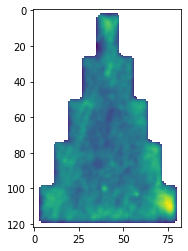

In [62]:
plt.imshow(datas[3][35])

In [ ]:
start = time.time()
        trainobjects, _, datas = getTrainObjects(oldLayers=datas, nextLayer=j, porositythreshold=setting.threshold)
        pred = justPredict ('A', trainobjects, setting.classifier, setting.type, setting.z, setting.xy, setting.bins, setting.hyperparameter)
        times.append(time.time() - start)
        if(len(times) % 100 == 0):
            print("Done with ", len(times))

In [116]:
asettings.iterrows()

<generator object DataFrame.iterrows at 0x159ce6970>

In [3]:
import time
import pathlib
start = time.time()
paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths][0:225]
paths_sorted.sort()
print(time.time() - start)

0.0036170482635498047
